In [ ]:
pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch
import pytorch_forecasting
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data_hf.csv')

In [ ]:
data.columns

Index(['Unnamed: 0.1', 'duration', 'instance', 'hyperflowId', 'cpu_processors',
       'cpu_physical_cores', 'cpu_cores', 'cpu_speed', 'nodes', 'size',
       'workflowName', 'Unnamed: 0', 'ds', 'jobs', 'cpu', 'memory', 'io_read',
       'io_readReal', 'io_readSyscalls', 'io_write', 'io_writeReal',
       'io_writeSyscalls', 'network_rxBytes', 'network_rxPackets',
       'network_txBytes', 'network_txPackets'],
      dtype='object')

In [ ]:
data = data.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis = 1)

In [ ]:
data['workflowName'] = data['workflowName'].astype('category')
data['instance'] = data['instance'].astype('category')

In [ ]:
data.head(2)

,duration,instance,hyperflowId,cpu_processors,cpu_physical_cores,cpu_cores,cpu_speed,nodes,size,workflowName,...,io_read,io_readReal,io_readSyscalls,io_write,io_writeReal,io_writeSyscalls,network_rxBytes,network_rxPackets,network_txBytes,network_txPackets
0,0 days 00:14:14.969000,n2d-standard-4,zTd2ID1yN,1.0,2.0,4.0,2.25,3,2.0,montage,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0 days 00:14:14.969000,n2d-standard-4,zTd2ID1yN,1.0,2.0,4.0,2.25,3,2.0,montage,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data['workflowName'].unique(), data['instance'].unique()

(['montage', 'montage2', 'soykb']
 Categories (3, object): ['montage', 'montage2', 'soykb'],
 ['n2d-standard-4', 'n2-standard-4', 't3.large', 'e2-standard-4', 'unassigned', 't3.2xlarge', 'n1-standard-4', 'e2-highmem-8', 'e2-medium', 'c2-standard-4']
 Categories (10, object): ['c2-standard-4', 'e2-highmem-8', 'e2-medium', 'e2-standard-4', ...,
                           'n2d-standard-4', 't3.2xlarge', 't3.large', 'unassigned'])

In [ ]:
data['ds'] = pd.to_datetime(data['ds'])

In [ ]:
data['ds'].shape

(135790,)

In [ ]:
data['ds'].unique().shape

(132840,)

In [ ]:
data['idx'] = [i for i in range(len(data['ds']))]

In [ ]:
data.dtypes

duration                      object
instance                    category
hyperflowId                   object
cpu_processors               float64
cpu_physical_cores           float64
cpu_cores                    float64
cpu_speed                    float64
nodes                          int64
size                         float64
workflowName                category
ds                    datetime64[ns]
jobs                           int64
cpu                          float64
memory                         int64
io_read                      float64
io_readReal                  float64
io_readSyscalls              float64
io_write                     float64
io_writeReal                 float64
io_writeSyscalls             float64
network_rxBytes              float64
network_rxPackets            float64
network_txBytes              float64
network_txPackets            float64
idx                            int64
dtype: object

In [ ]:
data['memory'] = data['memory'].astype('float64')

In [ ]:
data['jobs'] = data['jobs'].astype('float64')

In [ ]:
data = data.rename({'cpu':'cpu_usage'},axis = 1)

In [ ]:
for name in data.columns:
    print(name, data[name].isnull().values.any())

duration False
instance False
hyperflowId False
cpu_processors False
cpu_physical_cores False
cpu_cores False
cpu_speed False
nodes False
size False
workflowName False
ds False
jobs False
cpu_usage False
memory False
io_read False
io_readReal False
io_readSyscalls False
io_write False
io_writeReal False
io_writeSyscalls False
network_rxBytes False
network_rxPackets False
network_txBytes False
network_txPackets False
idx False


In [ ]:
import datetime
max_prediction_length = 6
max_encoder_length = 20
training_cutoff = pd.to_datetime(data["ds"].max() - pd.Timedelta(seconds = max_prediction_length*10))

training = TimeSeriesDataSet(
    data[lambda x: x.ds <= training_cutoff],
    time_idx='idx',
    target="cpu_usage",
    group_ids=['instance', 'workflowName'],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=['instance', 'workflowName'],
    time_varying_known_reals=['idx'],
    time_varying_unknown_categoricals=[],


    time_varying_unknown_reals=[
            'cpu_usage',
            'memory'
            ],
    target_normalizer=GroupNormalizer(
        groups=['instance', 'workflowName'], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
training.categoricals, training.flat_categoricals, training.reals, training.target_names, training.variable_to_group_mapping

(['instance', 'workflowName'],
 ['instance', 'workflowName'],
 ['encoder_length',
  'cpu_usage_center',
  'cpu_usage_scale',
  'idx',
  'relative_time_idx',
  'cpu_usage',
  'memory'],
 ['cpu_usage'],
 {})

In [ ]:
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
pl.seed_everything(42)
trainer = pl.Trainer(
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
    max_epochs=50,
    accelerator="auto"
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.20892961308540398,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 7.7k


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.06760829753919811
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.06760829753919811
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_3c34b9dd-05f9-4167-bc7f-c46723937eeb.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_3c34b9dd-05f9-4167-bc7f-c46723937eeb.ckpt


suggested learning rate: 0.06760829753919811


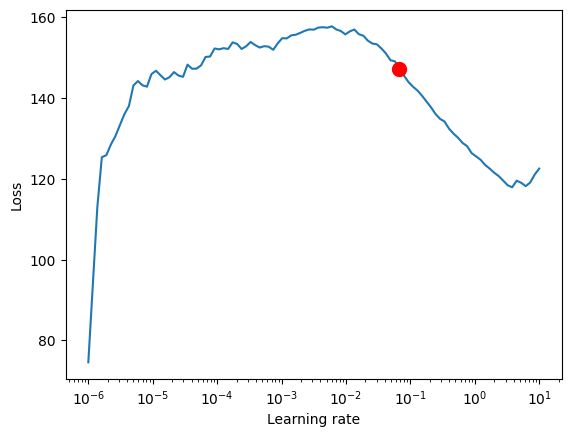

In [ ]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 69    
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 904   
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)

In [ ]:
predictions = tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))

In [ ]:
for idx in range(10):  # plot 10 examples
    tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)